# infer cosmology

In [1]:
import os
import h5py 
import numpy as np

In [2]:
import astropy.table as aTable

In [3]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [4]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# load $q_\phi(\theta_g), q_\phi(\theta_g\,|\,X), q_\phi(\theta_g\,|\,\theta_{\rm cosmo})$

In [6]:
dat_dir = '/tigress/chhahn/cgpop/'
qphi_thetag = torch.load(os.path.join(dat_dir, 'qphi.thetag.pt'), 
                         map_location=torch.device(device))
qphi_thetag._device = device
qphi_thetag_X = torch.load(os.path.join(dat_dir, 'qphi.thetag_X.pt'), 
                                    map_location=torch.device(device))
qphi_thetag_X._device = device
qphi_thetag_thetacosmo = torch.load(os.path.join(dat_dir, 'qphi.thetag_thetacosmo.pt'), 
                                    map_location=torch.device(device))
qphi_thetag_thetacosmo._device = device

# select NSA well within the support of CAMELS

In [7]:
nsa = aTable.Table.read(os.path.join(dat_dir, 'nsa_v0_1_2.fits'))

In [8]:
absmag_nsa = np.array(nsa['ABSMAG'].data)[:,3:] # g, r, i, z
ivar_absmag_nsa = np.array(nsa['AMIVAR'].data)[:,3:]

In [9]:
colors_nsa = np.array([absmag_nsa[:,0] - absmag_nsa[:,1], 
                         absmag_nsa[:,0] - absmag_nsa[:,2], 
                         absmag_nsa[:,0] - absmag_nsa[:,3], 
                         absmag_nsa[:,1] - absmag_nsa[:,2], 
                         absmag_nsa[:,1] - absmag_nsa[:,3],
                         absmag_nsa[:,2] - absmag_nsa[:,3]]).T

In [10]:
# cuts on absmag uncertainties
cuts = (np.all((ivar_absmag_nsa[:,:-1]**-0.5 > 0.02) & (ivar_absmag_nsa[:,:-1]**-0.5 < 0.022), axis=1) & 
        (ivar_absmag_nsa[:,-1]**-0.5 > 0.03) & (ivar_absmag_nsa[:,-1]**-0.5 < 0.04))
# cuts on absmag 
for i in range(4): 
    cuts = cuts & (absmag_nsa[:,i] < -16) & (absmag_nsa[:,i] > -20.)
# cuts on color 
cuts = cuts & (colors_nsa[:,0] > 0.264) & (colors_nsa[:,0] < 0.687)
cuts = cuts & (colors_nsa[:,1] > 0.423) & (colors_nsa[:,1] < 1.009)
cuts = cuts & (colors_nsa[:,2] > 0.538) & (colors_nsa[:,2] < 1.231)
cuts = cuts & (colors_nsa[:,3] > 0.151) & (colors_nsa[:,3] < 0.329)
cuts = cuts & (colors_nsa[:,4] > 0.263) & (colors_nsa[:,4] < 0.557)
cuts = cuts & (colors_nsa[:,5] > 0.097) & (colors_nsa[:,5] < 0.241)

np.sum(cuts)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


14359

# implement posterior evaluation using normalizing flows
$$p(\Omega\,|\,\{X_i\}) = p(\Omega) \prod_i^{N_g} \frac{1}{S} \sum\limits_j^{S} \frac{p(\theta^g_{i,j}\,|\,\Omega)}{p(\theta^g_{i,j})}$$

where $\theta^g_{i,j} \sim p(\theta^g\,|\,X_i)$

$$\log p(\Omega\,|\,\{X_i\}) = \log p(\Omega) + \sum\limits_i^{N_g} \sum\limits_j^{S} \frac{p(\theta^g_{i,j}\,|\,\Omega)}{p(\theta^g_{i,j})} - N_g \log S$$

In [40]:
def log_posterior_i(theta, post_i): 
    logp_thetag_thetacosmos = np.float(torch.logsumexp(qphi_thetag_thetacosmo.log_prob(torch.tensor(post_i).to(device),
                                x=torch.tensor(theta).to(device)), 0).cpu())
    logp_thetag = np.float(qphi_thetag.log_prob(torch.tensor(post_i).to(device)).cpu())
    return logp_thetag_thetacosmos - logp_thetag

def log_posterior(theta, posts): 
    if ((theta[0] < 0.15) | (theta[0] > 0.45) | (theta[1] < 0.65) | (theta[1] > 0.95) | 
        (theta[2] < 0.5) | (theta[2] > 3.0) | (theta[3] < 0.75) | (theta[3] > 1.75) | 
        (theta[4] < 0.5) | (theta[4] > 3.0) | (theta[5] < 0.75) | (theta[5] > 1.75)): 
        return -np.inf
    ngal = posts.shape[0]
    nsamp = posts.shape[1]
    
    # log p(thetag_ij | theta_cosmo)
    logprob = qphi_thetag_thetacosmo.log_prob(torch.tensor(np.concatenate(posts, axis=0)).to(device),
                                x=torch.tensor(theta).to(device)).reshape((ngal, nsamp))
    
    # log p(thetag_ij)
    logprior = qphi_thetag.log_prob(torch.tensor(np.concatenate(posts, axis=0)).to(device)).reshape((ngal, nsamp))

    return np.float(torch.sum(torch.logsumexp(logprob - logprior, 1)).cpu())

In [12]:
thetag_primes = []
for igal in range(10): 
    _X = np.concatenate([absmag_nsa[cuts][igal], ivar_absmag_nsa[cuts][igal]**-0.5])
    thetag_prime = qphi_thetag_X.sample((10000,), 
                                    x=torch.as_tensor(_X.astype(np.float32)).to(device), 
                                    show_progress_bars=True)
    thetag_primes.append(np.array(thetag_prime.cpu()))
thetag_primes = np.array(thetag_primes)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


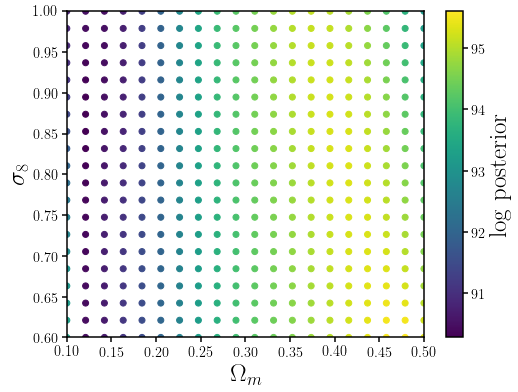

In [15]:
Oms = []
s8s = [] 
logposts = [] 
for om in np.linspace(0.1, 0.5, 20): 
    for s8 in np.linspace(0.6, 1., 20):
        Oms.append(om)
        s8s.append(s8)
        _logpost = log_posterior([om, s8, 1., 1., 1., 1.], thetag_primes)
        logposts.append(_logpost)

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
scat = sub.scatter(np.array(Oms), np.array(s8s), c=np.array(logposts))
sub.set_xlabel('$\Omega_m$', fontsize=25)
sub.set_xlim(0.1, 0.5)
sub.set_ylabel('$\sigma_8$', fontsize=25)
sub.set_ylim(0.6, 1.)
cb = plt.colorbar(scat)
cb.set_label('log posterior', fontsize=25)            
plt.show()

# now lets run MCMC!

In [14]:
import emcee 

In [21]:
ndim, nwalkers = 6, 20
p0 = 0.1 * np.random.randn(nwalkers, ndim) + np.array([0.3, 0.8, 1., 1., 1., 1.]) 

In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[thetag_primes])
# burn in
sampler.run_mcmc(p0, 500)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


State([[0.27051953 0.68883592 2.89449847 1.2320332  2.87977131 1.46644098]
 [0.36919453 0.75089039 2.88443111 1.50509615 1.60117306 1.31447527]
 [0.34539034 0.73393531 1.93422594 1.49512251 2.4787549  1.16013026]
 [0.41999478 0.66123725 2.27514701 1.68353383 2.49656209 1.15344565]
 [0.36919837 0.75670617 1.7480177  1.09917506 1.90782573 1.30018099]
 [0.35351881 0.65498744 2.18328215 0.84444629 1.28385508 1.14852431]
 [0.36201254 0.74835673 2.86107924 1.54345986 1.72269512 1.67735502]
 [0.31203375 0.69411754 2.36248555 1.39896175 2.81277222 1.0026266 ]
 [0.30031017 0.85354001 2.2945854  0.90527813 2.89520899 1.03535257]
 [0.36306324 0.93949837 2.63523757 1.25923311 1.57804535 1.70492491]
 [0.38288429 0.85285452 1.81781862 1.23048322 2.99657064 1.48108423]
 [0.29810819 0.79070865 2.62089048 1.23254837 2.29699892 1.64860512]
 [0.2863962  0.73525399 2.5162765  1.58883097 2.48682393 1.45459779]
 [0.3235462  0.6834716  2.26385086 1.36708931 2.52029794 1.43823459]
 [0.35367064 0.72075344 2.86

In [42]:
sampler.get_last_sample()

State([[0.27051953 0.68883592 2.89449847 1.2320332  2.87977131 1.46644098]
 [0.36919453 0.75089039 2.88443111 1.50509615 1.60117306 1.31447527]
 [0.34539034 0.73393531 1.93422594 1.49512251 2.4787549  1.16013026]
 [0.41999478 0.66123725 2.27514701 1.68353383 2.49656209 1.15344565]
 [0.36919837 0.75670617 1.7480177  1.09917506 1.90782573 1.30018099]
 [0.35351881 0.65498744 2.18328215 0.84444629 1.28385508 1.14852431]
 [0.36201254 0.74835673 2.86107924 1.54345986 1.72269512 1.67735502]
 [0.31203375 0.69411754 2.36248555 1.39896175 2.81277222 1.0026266 ]
 [0.30031017 0.85354001 2.2945854  0.90527813 2.89520899 1.03535257]
 [0.36306324 0.93949837 2.63523757 1.25923311 1.57804535 1.70492491]
 [0.38288429 0.85285452 1.81781862 1.23048322 2.99657064 1.48108423]
 [0.29810819 0.79070865 2.62089048 1.23254837 2.29699892 1.64860512]
 [0.2863962  0.73525399 2.5162765  1.58883097 2.48682393 1.45459779]
 [0.3235462  0.6834716  2.26385086 1.36708931 2.52029794 1.43823459]
 [0.35367064 0.72075344 2.86

In [35]:
sampler.get_chain().shape

(940, 20, 6)

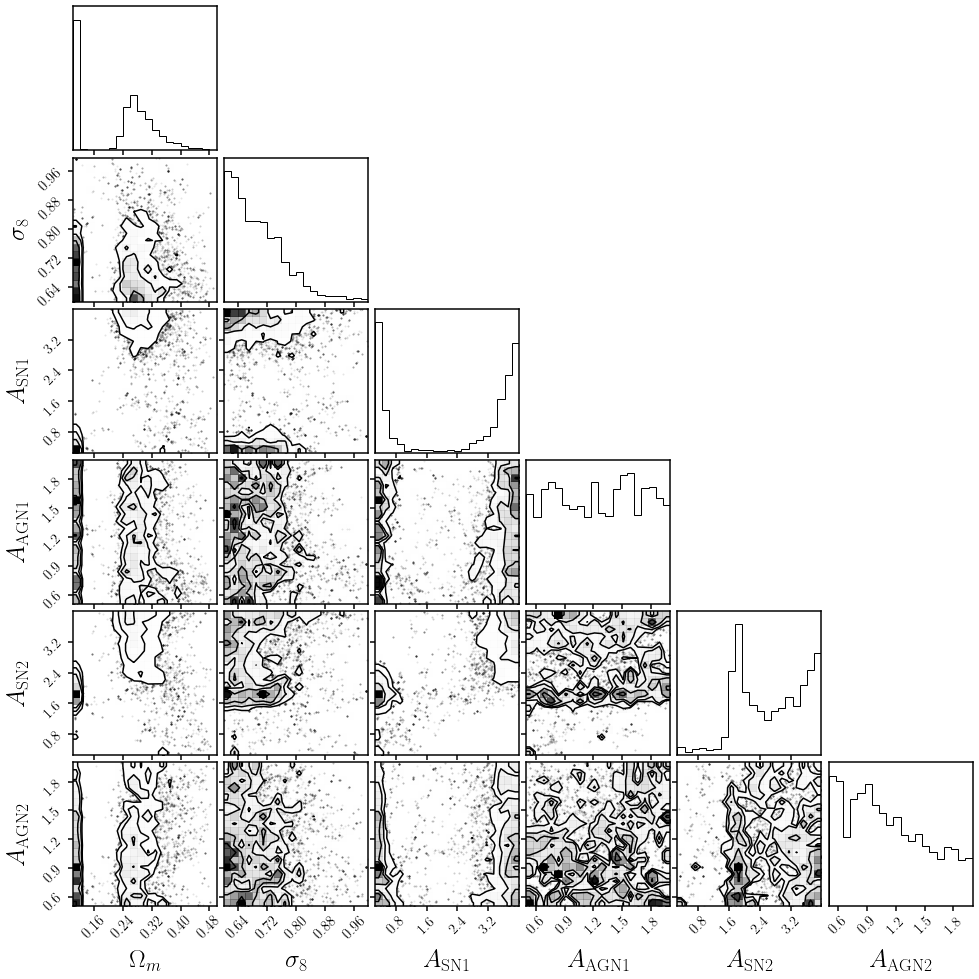

In [38]:
fig = DFM.corner(sampler.get_chain(flat=True)[20*100:], 
                labels=[r'$\Omega_m$', r'$\sigma_8$', r'$A_{\rm SN1}$', r'$A_{\rm AGN1}$', 
                        r'$A_{\rm SN2}$', r'$A_{\rm AGN2}$'], 
                label_kwargs={'fontsize': 25})